# csv데이터불러오기

In [2]:
import os
import heartpy as hp
import matplotlib.pyplot as plt
import numpy as np
import scipy
import csv
import math

In [40]:
# csv파일 불러와서 ppg_data로 반환
def load_data(path):
    f = open(path, 'r', encoding='utf-8')
    rdr = csv.reader(f)
    for line in rdr:
        ppg_data=line
    f.close()
    return ppg_data    

# 데이터 정규화 0~1

In [39]:
from sklearn.preprocessing import MinMaxScaler

def normalization(ppg_data):
    ppg_data=np.array(ppg_data)
    # MinMaxScaler객체 생성
    scaler = MinMaxScaler()
    # MinMaxScaler 로 데이터 셋 변환. fit() 과 transform() 호출.  
    scaler.fit(ppg_data.reshape(len(ppg_data),1))
    ppg_scaled = scaler.transform(ppg_data.reshape(len(ppg_data),1))
    print(type(ppg_scaled))
#     plt.plot(ppg_scaled)
#     plt.show()
    return ppg_scaled.reshape(len(ppg_data))

# peak detection

In [93]:
# peak 찾는 함수(amplitude)
def detect_peak(hrdata,distance,i):
    point=scipy.signal.find_peaks(hrdata,distance=distance)
#     print(point[0])
# point[0]가 peak의 x좌표 hrdata[point[0]]이 peak의 y좌표
#     plt.subplot(5,2,i+1)
#     plt.scatter(point[0],hrdata[point[0]])
#     plt.plot(hrdata)
#     plt.axis([500, 2000,0,1])
    peak=np.zeros(len(point[0]))
    for i in range(len(point[0])):
        peak[i]=(hrdata[point[0][i]])
#     print(peak)
# peak = peak 값 (y축값), point[0] = peak의 x위치
    return(peak,point[0])
# detect_peak(hrdata)

In [27]:
print(len(cppg_peaks))
print(len(rppg_peaks))
print(len(cppg_points))
print(len(rppg_points))  # peak개수 동일해지게끔 자동화함수만들기

NameError: name 'cppg_peaks' is not defined

In [28]:
#heartpy로 peak검출
import heartpy as hp
data = hp.get_data('D:\\prlab\\ysg\\HRV\\data\\ppg_signal\\cppg\\cppg11.csv')

working_data, measures = hp.process(cppg_scaled, 30)
hp.plotter(working_data, measures)

BadSignalWarning: 
----------------
Could not determine best fit for given signal. Please check the source signal.
 Probable causes:
- detected heart rate falls outside of bpmmin<->bpmmax constraints
- no detectable heart rate present in signal
- very noisy signal (consider filtering and scaling)
If you're sure the signal contains heartrate data, consider filtering and/or scaling first.
----------------


# 시간축으로 변환

In [106]:
# time은 sec
def Totimedomain(ppg_scaled,peaks_x,peaks_y):
    #data->timedomain
    # 1. 데이터 수만큼의 배열선언 2. 데이터로 시간을 넣어주기 ( 360초 / data수 )*(index+1)   # c 의 sr은 225, r 의 sr은 30 
    num=len(ppg_scaled)
    time=np.zeros_like(ppg_scaled,dtype=float)
    for i in range (len(time)):
        time[i]=round((360/num)*(i+1),4)
    
    #peak->timedomain
    #1.peak y 축 데이터 보존 , peak x 는 데이터 인덱스,,니까 peak_x=360/data수 * (index+1)
    ppg_peaks_x=np.zeros_like(peaks_x,dtype=float)
    for i in range (len(peaks_x)):
        ppg_peaks_x[i]=round(((360/num)*peaks_x[i]),4)
    
    
    plt.scatter(ppg_peaks_x, peaks_y)
    plt.plot(time,ppg_scaled)
    plt.axis([0,10,0,1])
    plt.xlabel('time')
    plt.ylabel('signal')
    plt.show()
    
    return time , ppg_peaks_x

#cppg_peaks,cppg_points= detect_peak(cppg_scaled,100,1)
#ctime,c_ppg_peaks_x=Totimedomain(cppg_scaled,cppg_points,cppg_peaks)

<class 'list'>
<class 'numpy.ndarray'>


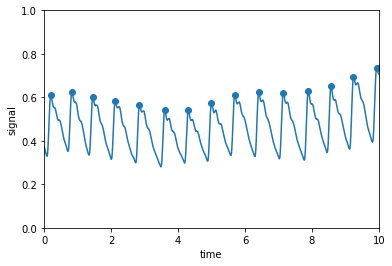

In [102]:
# 파일 하나씩 돌리기

import csv
# cppg불러오기
f = open('D:\\prlab\\ysg\\HRV\\data\\ppg_signal\\cppg\\cppg11.csv', 'r', encoding='utf-8')
rdr = csv.reader(f)
for line in rdr:
    cppg_data=line
    #print(line)
print(type(cppg_data))
f.close()   

# list를 numpy array로
cppg_data=np.array(cppg_data)
#rppg_data=np.array(rppg_data)
# 신호정규화 0~1사이값
cppg_scaled=normalization(cppg_data)
#rppg_scaled=normalization(rppg_data)
#peak 검출
cppg_peaks,cppg_points= detect_peak(cppg_scaled,100,1) # peak의 y값과 x값 반환 , 100
#타임도메인 전환
ctime,c_ppg_peaks_x=Totimedomain(cppg_scaled,cppg_points,cppg_peaks) # 정규화데이터, 피크x, 피크y

# 메인함수 실행

file_name cppg1.csv
<class 'numpy.ndarray'>


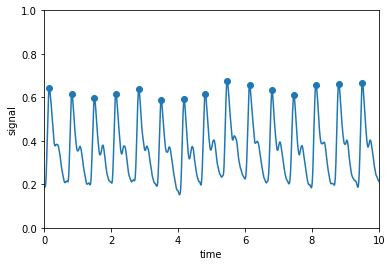

hrv_shape: (546,)
ppg_hrv_analysis: {'lf': 2.0636784128430964e-07, 'hf': 2.359015516893549e-06, 'lf_hf_ratio': 0.08748049336956609, 'lfnu': 8.04432759051219, 'hfnu': 91.9556724094878, 'total_power': 2.5980898290434553e-06, 'vlf': 3.2706470865596474e-08}
file_name cppg10.csv
<class 'numpy.ndarray'>


C:\Users\user\anaconda3\envs\hrv\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  warnings.warn('nperseg = {0:d} is greater than input length '


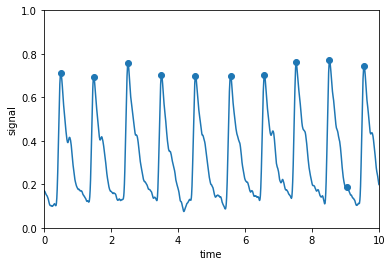

hrv_shape: (405,)
ppg_hrv_analysis: {'lf': 2.0977135590503946e-05, 'hf': 4.8809758533860425e-05, 'lf_hf_ratio': 0.42977339410420634, 'lfnu': 30.058846798829375, 'hfnu': 69.94115320117061, 'total_power': 7.677551084227341e-05, 'vlf': 6.988616717909044e-06}
file_name cppg2.csv
<class 'numpy.ndarray'>


C:\Users\user\anaconda3\envs\hrv\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  warnings.warn('nperseg = {0:d} is greater than input length '


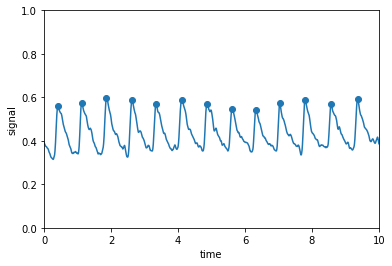

hrv_shape: (508,)
ppg_hrv_analysis: {'lf': 3.4504673735087195e-06, 'hf': 8.41155362145573e-06, 'lf_hf_ratio': 0.4102057157083867, 'lfnu': 29.088360027127575, 'hfnu': 70.91163997287244, 'total_power': 1.3004210484111253e-05, 'vlf': 1.1421894891468032e-06}
file_name cppg3.csv
<class 'numpy.ndarray'>


C:\Users\user\anaconda3\envs\hrv\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  warnings.warn('nperseg = {0:d} is greater than input length '


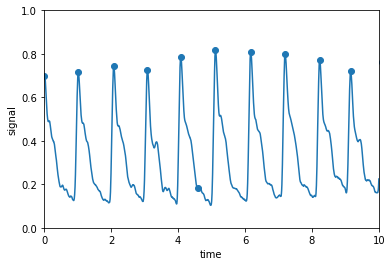

hrv_shape: (388,)
ppg_hrv_analysis: {'lf': 9.597979124395065e-06, 'hf': 2.7547783823717563e-05, 'lf_hf_ratio': 0.34841202420543105, 'lfnu': 25.838691583215244, 'hfnu': 74.16130841678475, 'total_power': 4.024331494000222e-05, 'vlf': 3.097551991889591e-06}
file_name cppg4.csv
<class 'numpy.ndarray'>


C:\Users\user\anaconda3\envs\hrv\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  warnings.warn('nperseg = {0:d} is greater than input length '


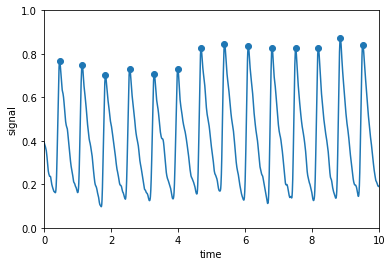

hrv_shape: (525,)
ppg_hrv_analysis: {'lf': 9.641707814478282e-06, 'hf': 2.2565860032639806e-05, 'lf_hf_ratio': 0.42726968086003736, 'lfnu': 29.936156186164848, 'hfnu': 70.06384381383516, 'total_power': 3.5417219311490934e-05, 'vlf': 3.2096514643728453e-06}
file_name cppg5.csv
<class 'numpy.ndarray'>


C:\Users\user\anaconda3\envs\hrv\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  warnings.warn('nperseg = {0:d} is greater than input length '


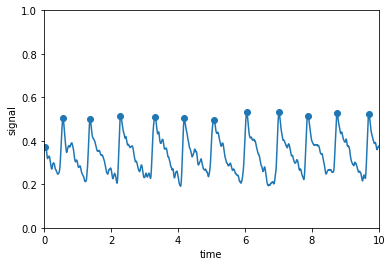

hrv_shape: (423,)
ppg_hrv_analysis: {'lf': 0.000500619858607154, 'hf': 0.0011456508931539126, 'lf_hf_ratio': 0.4369741791314592, 'lfnu': 30.409327145709508, 'hfnu': 69.59067285429049, 'total_power': 0.0018134225252700556, 'vlf': 0.00016715177350898886}
file_name cppg6.csv
<class 'numpy.ndarray'>


C:\Users\user\anaconda3\envs\hrv\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  warnings.warn('nperseg = {0:d} is greater than input length '


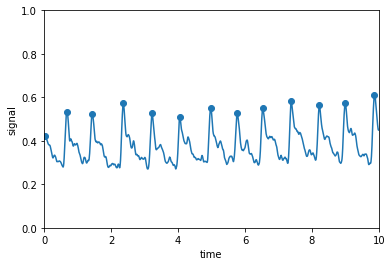

hrv_shape: (436,)
ppg_hrv_analysis: {'lf': 0.0002970616122463386, 'hf': 0.0006801970372048085, 'lf_hf_ratio': 0.4367287653399361, 'lfnu': 30.39744006493837, 'hfnu': 69.60255993506162, 'total_power': 0.001076437108800184, 'vlf': 9.917845934903714e-05}
file_name cppg7.csv
<class 'numpy.ndarray'>


C:\Users\user\anaconda3\envs\hrv\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  warnings.warn('nperseg = {0:d} is greater than input length '


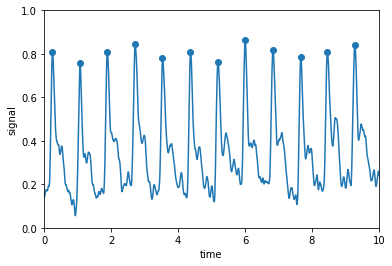

hrv_shape: (447,)
ppg_hrv_analysis: {'lf': 3.2396456390181946e-06, 'hf': 8.634862127103156e-06, 'lf_hf_ratio': 0.37518209223625887, 'lfnu': 27.282357322305934, 'hfnu': 72.71764267769407, 'total_power': 1.2932765818287575e-05, 'vlf': 1.058258052166225e-06}
file_name cppg8.csv
<class 'numpy.ndarray'>


C:\Users\user\anaconda3\envs\hrv\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  warnings.warn('nperseg = {0:d} is greater than input length '


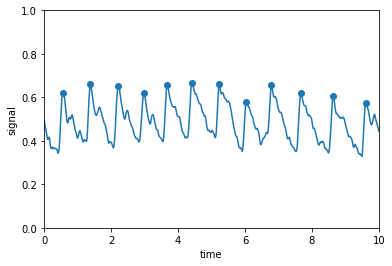

hrv_shape: (441,)
ppg_hrv_analysis: {'lf': 9.306538240840592e-08, 'hf': 3.9719220515730093e-07, 'lf_hf_ratio': 0.23430817926436656, 'lfnu': 18.982956055918834, 'hfnu': 81.01704394408117, 'total_power': 5.177969506071499e-07, 'vlf': 2.7539363041443098e-08}
file_name cppg9.csv
<class 'numpy.ndarray'>


C:\Users\user\anaconda3\envs\hrv\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  warnings.warn('nperseg = {0:d} is greater than input length '


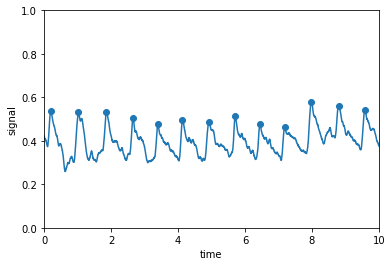

hrv_shape: (476,)
ppg_hrv_analysis: {'lf': 2.6368670428059745e-06, 'hf': 6.499991066546197e-06, 'lf_hf_ratio': 0.40567241028641704, 'lfnu': 28.859669387959176, 'hfnu': 71.14033061204081, 'total_power': 1.0008347762038113e-05, 'vlf': 8.714896526859406e-07}
file_name cppg11.csv
<class 'numpy.ndarray'>


C:\Users\user\anaconda3\envs\hrv\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  warnings.warn('nperseg = {0:d} is greater than input length '


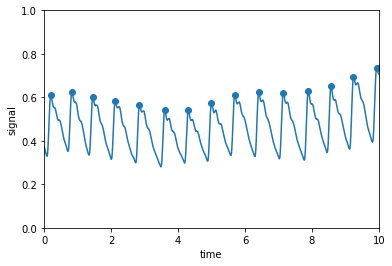

hrv_shape: (519,)
ppg_hrv_analysis: {'lf': 3.012681431613843e-05, 'hf': 7.178103662017552e-05, 'lf_hf_ratio': 0.4197043639192956, 'lfnu': 29.56280015655105, 'hfnu': 70.43719984344895, 'total_power': 0.00011191245537511901, 'vlf': 1.0004604438805064e-05}
file_name cppg12.csv
<class 'numpy.ndarray'>


C:\Users\user\anaconda3\envs\hrv\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  warnings.warn('nperseg = {0:d} is greater than input length '


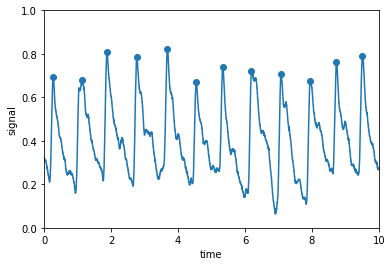

hrv_shape: (450,)
ppg_hrv_analysis: {'lf': 4.156444670116183e-05, 'hf': 9.693033463662633e-05, 'lf_hf_ratio': 0.4288074198544672, 'lfnu': 30.01156166295272, 'hfnu': 69.98843833704727, 'total_power': 0.0001523379634280233, 'vlf': 1.3843182090235124e-05}


C:\Users\user\anaconda3\envs\hrv\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  warnings.warn('nperseg = {0:d} is greater than input length '


In [117]:
# 파일 한번에 돌리기.
import os
from hrvanalysis import get_frequency_domain_features

def hrv_frequency(c_or_r,distance):
    if c_or_r ==0:
        filepath="D:\\prlab\\ysg\\HRV\\data\\ppg_signal\\cppg"
        filelist=os.listdir(filepath)
        #print(filelist)

    else :
        filepath="D:\\prlab\\ysg\\HRV\\data\\ppg_signal\\rppg"
        filelist=os.listdir(filepath)
        print(filelist)
        for i in range (len(filelist)):
            path=filepath+'\\'+filelist[i]
            
            
    for i in range (len(filelist)):
        print("file_name",filelist[i])
        path=filepath+'\\'+filelist[i]
        ppg_data=load_data(path) # 1. ppg data 하나씩 load
        ppg_scaled=normalization(ppg_data) # 2. 정규화 0~1
        ppg_peaks,ppg_points=detect_peak(ppg_scaled,distance,i)# 3, peak detect , peak의 y,x 값 리턴
        time,ppg_peaks_x=Totimedomain(ppg_scaled,ppg_points,ppg_peaks) # 4. 타임도메인 전환(정규화데이터, 피크x, 피크y)
        
        ppg_hrv=cal_hrv(ppg_peaks,ppg_peaks_x) # 5. hrv계산
        ppg_frequency_features = get_frequency_domain_features(ppg_hrv)
        print("ppg_hrv_analysis:",ppg_frequency_features)
    
hrv_frequency(0,130)

['rppg1.csv', 'rppg10.csv', 'rppg2.csv', 'rppg3.csv', 'rppg4.csv', 'rppg5.csv', 'rppg6.csv', 'rppg7.csv', 'rppg8.csv', 'rppg9.csv', 'rppg11.csv', 'rppg12.csv']
file_name rppg1.csv
<class 'numpy.ndarray'>


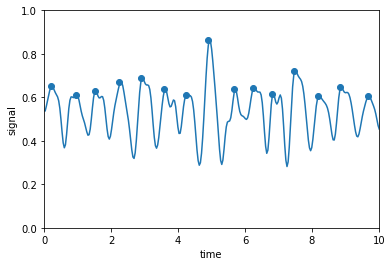

hrv_shape: (546,)
ppg_hrv_analysis: {'lf': 1.810961631102458e-05, 'hf': 4.438506681065951e-05, 'lf_hf_ratio': 0.4080114689987439, 'lfnu': 28.97785124498214, 'hfnu': 71.02214875501784, 'total_power': 6.848485615255006e-05, 'vlf': 5.990173030865967e-06}
file_name rppg10.csv
<class 'numpy.ndarray'>


C:\Users\user\anaconda3\envs\hrv\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  warnings.warn('nperseg = {0:d} is greater than input length '


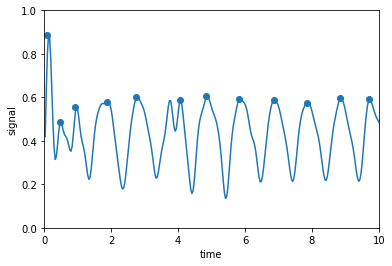

hrv_shape: (400,)
ppg_hrv_analysis: {'lf': 0.0007923245304416094, 'hf': 0.0018126644070094585, 'lf_hf_ratio': 0.43710491990560446, 'lfnu': 30.415658164632507, 'hfnu': 69.5843418353675, 'total_power': 0.0028695482774054484, 'vlf': 0.0002645593399543805}
file_name rppg2.csv
<class 'numpy.ndarray'>


C:\Users\user\anaconda3\envs\hrv\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  warnings.warn('nperseg = {0:d} is greater than input length '


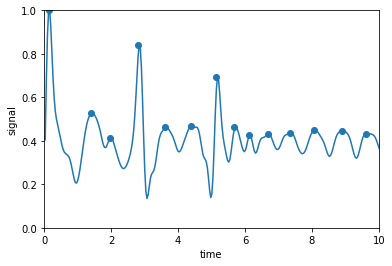

C:\Users\user\anaconda3\envs\hrv\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  warnings.warn('nperseg = {0:d} is greater than input length '


hrv_shape: (510,)
ppg_hrv_analysis: {'lf': 0.0027821979020908635, 'hf': 0.006356154970685802, 'lf_hf_ratio': 0.43771712850334676, 'lfnu': 30.445288563752953, 'hfnu': 69.55471143624705, 'total_power': 0.010067507198991257, 'vlf': 0.0009291543262145922}
file_name rppg3.csv
<class 'numpy.ndarray'>


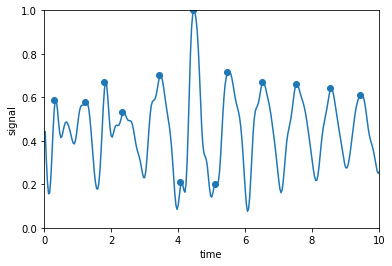

C:\Users\user\anaconda3\envs\hrv\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  warnings.warn('nperseg = {0:d} is greater than input length '


hrv_shape: (387,)
ppg_hrv_analysis: {'lf': 1.7211623961395452e-05, 'hf': 3.969761160014211e-05, 'lf_hf_ratio': 0.4335682492629818, 'lfnu': 30.243990789129537, 'hfnu': 69.75600921087046, 'total_power': 6.265008189864999e-05, 'vlf': 5.7408463371124275e-06}
file_name rppg4.csv
<class 'numpy.ndarray'>


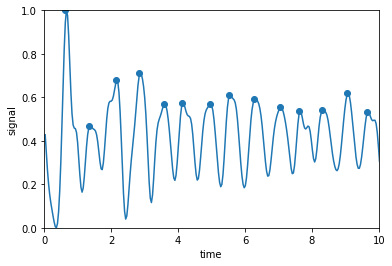

C:\Users\user\anaconda3\envs\hrv\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  warnings.warn('nperseg = {0:d} is greater than input length '


hrv_shape: (525,)
ppg_hrv_analysis: {'lf': 0.00019832384385634535, 'hf': 0.0004553745955726045, 'lf_hf_ratio': 0.43551802358883407, 'lfnu': 30.338736012525093, 'hfnu': 69.6612639874749, 'total_power': 0.000719887598999071, 'vlf': 6.618915957012114e-05}
file_name rppg5.csv
<class 'numpy.ndarray'>


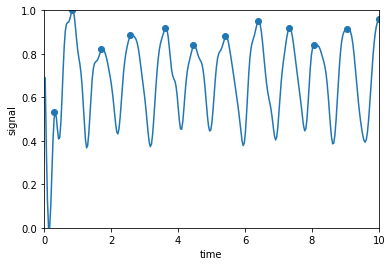

C:\Users\user\anaconda3\envs\hrv\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  warnings.warn('nperseg = {0:d} is greater than input length '


hrv_shape: (423,)
ppg_hrv_analysis: {'lf': 0.00011614421235306339, 'hf': 0.00026710520208697705, 'lf_hf_ratio': 0.43482572202110664, 'lfnu': 30.305124542136568, 'hfnu': 69.69487545786343, 'total_power': 0.0004220035659149337, 'vlf': 3.875415147489325e-05}
file_name rppg6.csv
<class 'numpy.ndarray'>


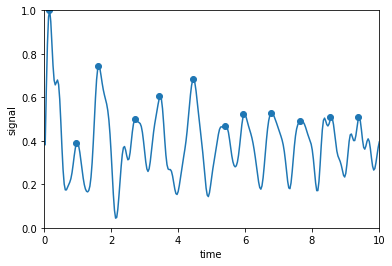

C:\Users\user\anaconda3\envs\hrv\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  warnings.warn('nperseg = {0:d} is greater than input length '


hrv_shape: (445,)
ppg_hrv_analysis: {'lf': 0.00013803092228998172, 'hf': 0.0003873848793008036, 'lf_hf_ratio': 0.35631468770571445, 'lfnu': 26.270797694334608, 'hfnu': 73.7292023056654, 'total_power': 0.0005701310395418212, 'vlf': 4.471523795103582e-05}
file_name rppg7.csv
<class 'numpy.ndarray'>


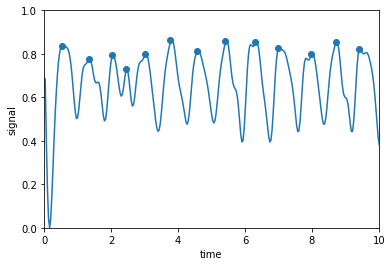

C:\Users\user\anaconda3\envs\hrv\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  warnings.warn('nperseg = {0:d} is greater than input length '


hrv_shape: (448,)
ppg_hrv_analysis: {'lf': 1.5746370431043893e-06, 'hf': 8.919160027434755e-06, 'lf_hf_ratio': 0.17654544130399144, 'lfnu': 15.005407790142147, 'hfnu': 84.99459220985784, 'total_power': 1.0917570245688849e-05, 'vlf': 4.2377317514970346e-07}
file_name rppg8.csv
<class 'numpy.ndarray'>


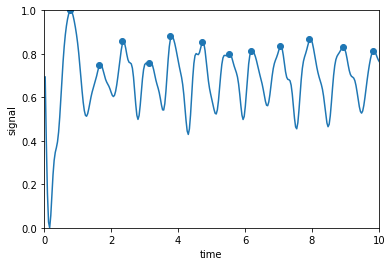

C:\Users\user\anaconda3\envs\hrv\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  warnings.warn('nperseg = {0:d} is greater than input length '


hrv_shape: (442,)
ppg_hrv_analysis: {'lf': 0.00011526378348481661, 'hf': 0.00027327328216305636, 'lf_hf_ratio': 0.4217894357343034, 'lfnu': 29.66609718241887, 'hfnu': 70.33390281758113, 'total_power': 0.00042684026058016145, 'vlf': 3.830319493228845e-05}
file_name rppg9.csv
<class 'numpy.ndarray'>


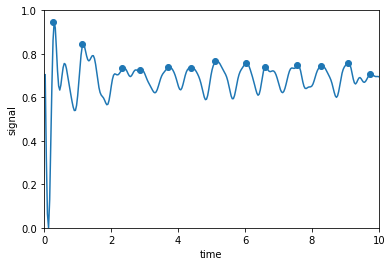

C:\Users\user\anaconda3\envs\hrv\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  warnings.warn('nperseg = {0:d} is greater than input length '


hrv_shape: (480,)
ppg_hrv_analysis: {'lf': 5.7653554579206375e-05, 'hf': 0.00013171455853639775, 'lf_hf_ratio': 0.4377158851675041, 'lfnu': 30.445228412879853, 'hfnu': 69.55477158712013, 'total_power': 0.0002086223256389005, 'vlf': 1.9254212523296368e-05}
file_name rppg11.csv
<class 'numpy.ndarray'>


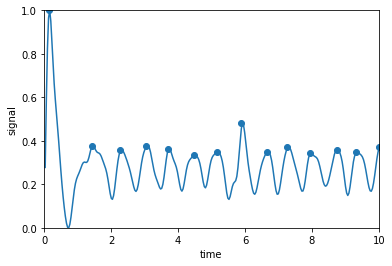

C:\Users\user\anaconda3\envs\hrv\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  warnings.warn('nperseg = {0:d} is greater than input length '


hrv_shape: (517,)
ppg_hrv_analysis: {'lf': 0.004082194719560577, 'hf': 0.009328061390131138, 'lf_hf_ratio': 0.4376251987234389, 'lfnu': 30.44084084725524, 'hfnu': 69.55915915274477, 'total_power': 0.014773525167998569, 'vlf': 0.001363269058306854}
file_name rppg12.csv
<class 'numpy.ndarray'>


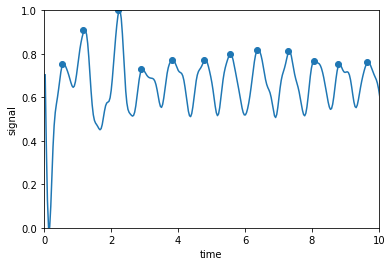

hrv_shape: (450,)
ppg_hrv_analysis: {'lf': 0.00021031628066498054, 'hf': 0.0004914652741888774, 'lf_hf_ratio': 0.42793721491735115, 'lfnu': 29.968909728437893, 'hfnu': 70.0310902715621, 'total_power': 0.0007718089817770942, 'vlf': 7.00274269232363e-05}


C:\Users\user\anaconda3\envs\hrv\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 3, using nperseg = 3
  warnings.warn('nperseg = {0:d} is greater than input length '


In [118]:
hrv_frequency(1,11)

# 신호전처리(노이즈제거)

# RR-interval 구하기

In [111]:
# print(cppg_points.shape)
# print(rppg_points.shape)
def length(x1,y1,x2,y2):
    return math.sqrt(math.pow(x2-x1,2)+math.pow(y2-y1,2))

def cal_hrv(peak_y,peak_x):
    hrv=np.zeros(len(peak_x)-1)
    print("hrv_shape:", hrv.shape)
    for i in range (len(peak_x)-1):
        peak_dist= length(peak_x[i],peak_y[i],peak_x[i+1],peak_y[i+1])
#         print(peak_dist)
        hrv[i]=peak_dist
    #print(hrv)
    return hrv

# cppg_hrv=cal_hrv(cppg_peaks,cppg_points)
# rppg_hrv=cal_hrv(rppg_peaks,rppg_points)


# print(cppg_points.shape)#peak의 x좌표
# print(cppg_peaks.shape)#peak의 y좌표
#length(cppg_points[0],cppg_peaks[0],cppg_points[1],cppg_peaks[1])

# hrv feature

In [53]:
from hrvanalysis import get_frequency_domain_features
cppg_frequency_features = get_frequency_domain_features(cppg_hrv)
rppg_frequency_features = get_frequency_domain_features(rppg_hrv)

print("cppg:",cppg_frequency_features)
print("rppg:",rppg_frequency_features)


cppg: {'lf': 45.79238640898639, 'hf': 69.37915524743643, 'lf_hf_ratio': 0.660030901870608, 'lfnu': 39.76015754446807, 'hfnu': 60.23984245553192, 'total_power': 136.3851235221748, 'vlf': 21.21358186575197}
rppg: {'lf': 0.08553989713063168, 'hf': 0.086581221825979, 'lf_hf_ratio': 0.9879728574697144, 'lfnu': 49.69750234554023, 'hfnu': 50.30249765445976, 'total_power': 0.18736122172144498, 'vlf': 0.015240102764834307}


C:\Users\ysk00\Anaconda3\envs\hrv\lib\site-packages\scipy\signal\spectral.py:1963: UserWarning: nperseg = 256 is greater than input length  = 76, using nperseg = 76
  .format(nperseg, input_length))


# csv로 기록

In [69]:
cppg_frequency_features['name']="soeui"
print(cppg_frequency_features.values())
f = open('D:\\prlab\\ysg\\HRV\\data\\hrv_feature\\cppg.csv','w', newline='')
# fieldnames=cppg_frequency_features.keys()
# print(fieldnames)
wr = csv.writer(f)
wr.writerow(cppg_frequency_features.keys()) 
wr.writerow(cppg_frequency_features.values()) 
f.close()

dict_values([0.10822306266329913, 0.50597153800256, 0.21389160167098484, 17.62032140073726, 82.37967859926273, 0.6211251835636167, 0.006930582897757498, 'soeui'])


In [ ]:
rppg_frequency_features['name']="soeui"
print(cppg_frequency_features.values())
f = open('D:\\prlab\\ysg\\HRV\\data\\hrv_feature\\rppg.csv','w', newline='')
# fieldnames=cppg_frequency_features.keys()
# print(fieldnames)
wr = csv.writer(f)
wr.writerow(rppg_frequency_features.keys()) 
wr.writerow(rppg_frequency_features.values()) 
f.close()